In [117]:
# import sys
# sys.path.insert(0,'/home/kmatsuno/h5py/build/lib.linux-x86_64-2.7/')
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import numpy as np
import floatpy.readers.padeops_reader as por
import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.common import *
from scripts.decorr_lscale_y import get_L99

def visualize_one(reader, step, qname, plane, cmap, dtheta=0,domega=0,savename=''):
    reader.step = step
    fs = 12
    q = reader.readData(qname)
    q = np.squeeze(np.array(q))
    
    fig = plt.figure(figsize=(4,6), dpi=200) 
    axarr = plt.axes()

    # Plot the colors
    if plane=='xy': data2plot = np.fliplr(np.transpose(q))
    if plane=='xz': data2plot = np.transpose(q)
    im = axarr.imshow( data2plot, cmap=cmap, origin='lower', interpolation='nearest')#spline36
    axarr.set_xticks([])
    axarr.set_yticks([]) 
    #axarr.set_ylim([Ny/2-200,Ny/2+200])
    axarr.set_title(r'Time: t = ' + str(np.around(reader.time,-1)),size=fs)
    
    axarr.set_xlabel('x')
    if plane=='xy':axarr.set_ylabel('y')
    if plane=='xz':axarr.set_ylabel('z')
    
    # set the colorbar
    divider1 = make_axes_locatable(axarr)
    cax = divider1.append_axes('right', size='5%', pad=0.1)
    maxval = np.amax(q);
    minval = np.amin(q);
    cbar = plt.colorbar(im, cax,ticks=[minval, maxval])
    cbar.ax.set_yticklabels(['%0.2f'%(minval), '%0.2f'%(maxval)]) 
    cbar.ax.tick_params(labelsize=0.75*fs)    
    
    # overlay the centerline, momentum and vorticity thickness
    if plane=='xy' and (dtheta>0 or domega>0):
        xplot = np.linspace(0,Nx-1,10)
        ones = np.ones(np.shape(xplot))
        centerline = Ny/2*ones
        lw = 0.5
        axarr.plot(xplot,centerline,'k-',alpha=0.5,linewidth=lw)
        if (domega>0):
            axarr.plot(xplot,centerline+dy*domega,'k-.',alpha=0.5,linewidth=lw)
            axarr.plot(xplot,centerline-dy*domega,'k-.',alpha=0.5,linewidth=lw)
        if (dtheta>0):
            axarr.plot(xplot,centerline+dy*dtheta,'k--',alpha=0.5,linewidth=lw)
            axarr.plot(xplot,centerline-dy*dtheta,'k--',alpha=0.5,linewidth=lw)
        # Get utilde, normalize by L99:
        fname = filename_prefix+'utilde_%04d.dat'%tID
        utilde = np.fromfile(fname,count=-1,sep=' ')
        L99,itop,ibot = get_L99(yplot,utilde)
    
    # set the overall title and save
    if savename:
        plt.savefig(savename, dpi=500)#, bbox_inches='tight',pan_inches=0.5)
        plt.close(fig)
        print "Saved plot to ",savename
    else: plt.show
    

In [257]:
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/'

filename_prefix = directory+'/shearlayer_'
reader = por.PadeopsReader(filename_prefix, periodic_dimensions=(True,False,True))
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
yplot = np.linspace(-Ly/2,Ly/2,int(Ny))
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

steps = sorted(reader.steps)
print("Steps: {}".format(steps))

dir_out = directory.split('/projects/ShockInducedMix/')[-1]
dir_out = '/home/kmatsuno/' + dir_out + '/'


Params for this run:
	Mc = 2.0
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 80.0x80.0x40.0
Steps: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


2.0
L99=37.9820317899
/home/kmatsuno/ShearLayerData/production/Mc20/rr1/1024x1448x512///autocorr_vv_0013.h5
(0.14412330090594622, 0.08243675528475423)


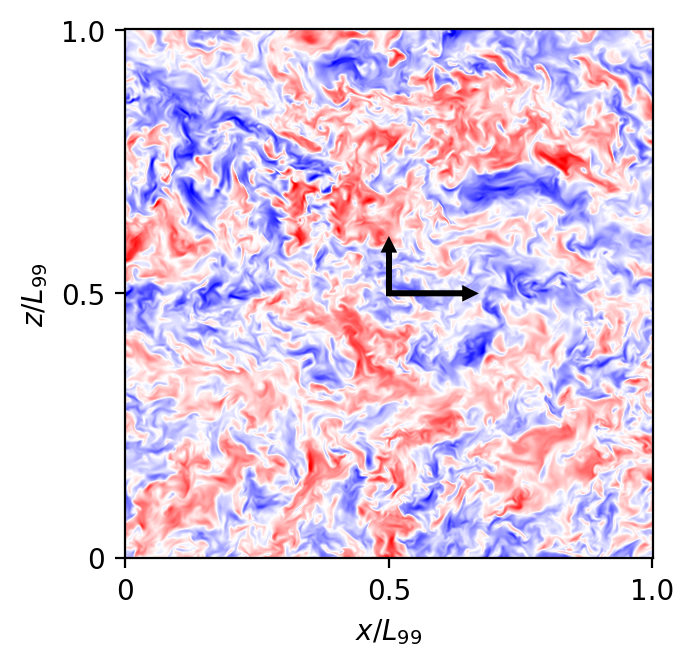

In [258]:
def visualize_normL99_xz(reader, step, qname, cmap, inp=None, savename=''):
    reader.step = step
    fs = 10
    q = reader.readData(qname)
    q = np.squeeze(np.array(q))
    if qname is 'v': q /= inp.du # for velocity only!

    # Get utilde, normalize by L99:
    fname = filename_prefix+'utilde_%04d.dat'%step
    utilde = np.fromfile(fname,count=-1,sep=' ')
    L99,itop,ibot = get_L99(yplot,utilde)
    print('L99={}'.format(L99))
    
    # Corresponding nx,nz for one L99?
    nx = Nx*L99/Lx
    nz = Nz*L99/Lz
    
    fig = plt.figure(figsize=(3.5,3.5), dpi=200) 
    axarr = plt.axes()

    # Plot the colors
    data2plot = np.fliplr(np.transpose(q))
    im = axarr.imshow( data2plot, cmap=cmap, vmin=-qmax,vmax=qmax,origin='lower', interpolation='spline36',aspect='equal')#spline36
    plt.xticks([0,nx/2.,nx-1],['0','0.5','1.0'])
    plt.yticks([0,nz/2,nz-1],['0','0.5','1.0'])#'%0.2f'%(-Ly/L99*ibot/Ny),'0','%0.2f'%(Ly/L99*ibot/Ny)])
    axarr.set_xlim([0,nx])    
    axarr.set_ylim([0,nz])    
    axarr.set_xlabel(r'$x/L_{99}$')
    axarr.set_ylabel(r'$z/L_{99}$')
    
    # Plot the Lx,Ly lengthscales:
    x = np.linspace(0,Lx,Nx)
    z = np.linspace(0,Lz,Nz)
    if inp.rr==1:
        fname = dir_out+'/autocorr_%s%s_%04d.h5'%(qname,qname,step)
        print(fname)
        hf =  h5py.File(fname,'r')
        autocorr = np.mean(hf['qx'],axis=-1)
        autocorr = np.fft.fftshift(autocorr)
        lx = get_lscale(x,autocorr,thresh=0.2)        
        autocorr = np.mean(hf['qz'],axis=0)
        autocorr = np.fft.fftshift(autocorr)
        #plt.figure();plt.plot(autocorr)
        lz = get_lscale(z,autocorr,thresh=0.2)
        print(lx/L99,lz/L99)
    # Corresponding nx,nz for lx,lz?
    nx_decorr = nx*lx/L99
    nz_decorr = nz*lz/L99
    plt.arrow(nx/2,nz/2,nx_decorr,0,ec='k',fc='k',lw=2,head_width=7, head_length=7)
    plt.arrow(nx/2,nz/2,0,nz_decorr,ec='k',fc='k',lw=2,head_width=7, head_length=7)
    
    # set the colorbar
#     divider1 = make_axes_locatable(axarr)
#     cax = divider1.append_axes('top', size='3%', pad=0.25)
#     maxval = 0.5
#     minval = -0.5
#     cbar = plt.colorbar(im, cax,orientation='horizontal',ticks=[minval, maxval])
#     cbar.ax.set_yticklabels(['%0.2f'%(minval), '%0.2f'%(maxval)]) 
#     cbar.ax.tick_params(labelsize=0.75*fs)    

qmax = 0.5
print(inp.Mc)
yslice = Ny/2
reader.sub_domain = (0,yslice,0), (reader.domain_size[0]-1, yslice,reader.domain_size[2]-1,)
step = max(steps)
visualize_normL99_xz(reader, step, 'v', 'seismic', inp=inp, savename='')

0.2
L99=44.0912232205
/home/kmatsuno/ShearLayerData/production/Mc02/rr1/1024x1448x512///autocorr_vv_0112.h5


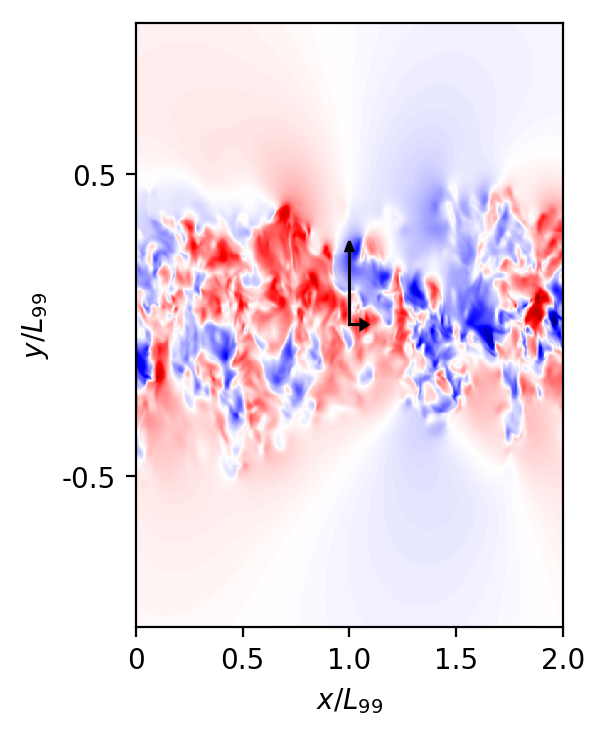

In [250]:
def visualize_normL99_xy(reader, step, qname, cmap, inp=None, savename=''):
    reader.step = step
    fs = 10
    q = reader.readData(qname)
    q = np.squeeze(np.array(q))
    if qname is 'v': q /= inp.du # for velocity only!
    
    # Get utilde, normalize by L99:
    fname = filename_prefix+'utilde_%04d.dat'%step
    utilde = np.fromfile(fname,count=-1,sep=' ')
    L99,itop,ibot = get_L99(yplot,utilde)
    print('L99={}'.format(L99))

    # Corresponding nx,ny for one L99?
    nx = Nx*L99/Lx
    ny = Ny*L99/Ly
    
    fig = plt.figure(figsize=(4,4), dpi=200) 
    axarr = plt.axes()

    # Plot the colors
    data2plot = np.fliplr(np.transpose(q))
    im = axarr.imshow( data2plot, cmap=cmap, origin='lower', 
                      interpolation='nearest',aspect=Ly/Lx,vmin=-qmax,vmax=qmax)#spline36
    
    # Plot the Ly lengthscales:
    fname = dir_out+'/lscale_%s%s_%04d.dat'%(qname,qname,step)
    autocorr = np.fromfile(fname,sep=' ')
    autocorr = np.reshape(autocorr,[Ny,3])
    autocorr = autocorr[:,0]
    ly = get_lscale(y,autocorr,thresh=0.25)
    ny_decorr = ny*ly/L99
    plt.arrow(nx,Ny/2,0,ny_decorr,ec='k',fc='k',head_width=10, head_length=10)
#     plt.arrow(nx,Ny/2,0,-ny_decorr/2,ec='k',fc='k',head_width=20, head_length=20)
    
    # Plot the Lx lengthscales:
    x = np.linspace(0,Lx,Nx)
    if inp.rr==1:
        fname = dir_out+'/autocorr_%s%s_%04d.h5'%(qname,qname,step)
        print(fname)
        hf =  h5py.File(fname,'r')
        autocorr = np.mean(hf['qx'],axis=-1)
        autocorr = np.fft.fftshift(autocorr)
        #plt.figure();plt.plot(autocorr)
        lx = get_lscale(x,autocorr,thresh=0.2)
    # Corresponding nx,ny for lx,ly?
    nx_decorr = nx*lx/L99
    plt.arrow(nx,Ny/2,nx_decorr,0,ec='k',fc='k',head_width=10, head_length=10)
#     plt.arrow(nx,Ny/2,-nx_decorr,0,ec='k',fc='k',head_width=20, head_length=20)
    
    # Set axis
    plt.xticks([0,nx/2.,nx,nx*1.5,nx*2],['0','0.5','1.0','1.5','2.0'])
    plt.yticks([Ny/2-ny/2,0,Ny/2+ny/2],['-0.5','0','0.5'])
    axarr.set_ylim([Ny/2-ny,Ny/2+ny])    
    axarr.set_xlim([0,nx*2])    
    axarr.set_xlabel(r'$x/L_{99}$')
    axarr.set_ylabel(r'$y/L_{99}$')
    
    # set the colorbar
#     divider1 = make_axes_locatable(axarr)
#     cax = divider1.append_axes('top', size='3%', pad=0.25)
#     cbar = plt.colorbar(im, cax,orientation='horizontal',ticks=[-qmax, qmax])
#     cbar.ax.set_yticklabels(['%0.2f'%(-qmax), '%0.2f'%(qmax)]) 
#     cbar.ax.tick_params(labelsize=0.75*fs)    

print(inp.Mc)
qmax=0.5
zslice = Nz/2
reader.sub_domain = (0,0,zslice), (reader.domain_size[0]-1, reader.domain_size[1]-1, zslice)
step = max(steps)-1
visualize_normL99_xy(reader, step, 'v', 'seismic', inp=inp, savename='')

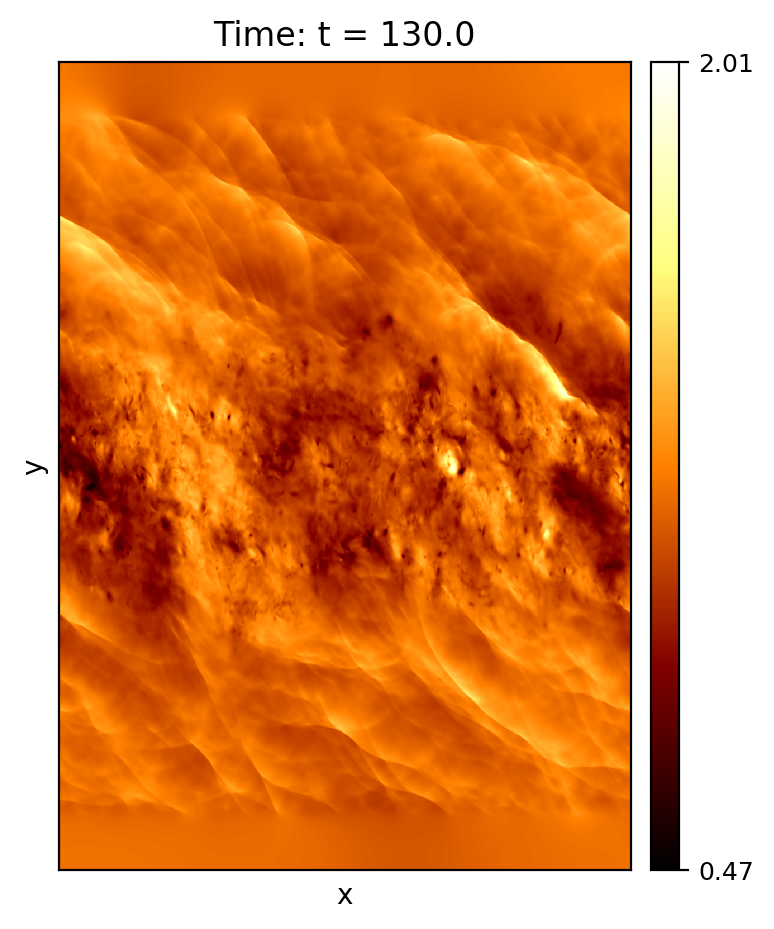

In [4]:
# plot a streamwise xy slice

zslice = Nz/2
reader.sub_domain = (0,0,zslice), (reader.domain_size[0]-1, reader.domain_size[1]-1, zslice)
step = max(steps)
visualize_one(reader, step, qname='p', plane='xy',cmap='afmhot',dtheta=0,domega=0,savename="") 

#'inferno','afmhot','viridis'

724


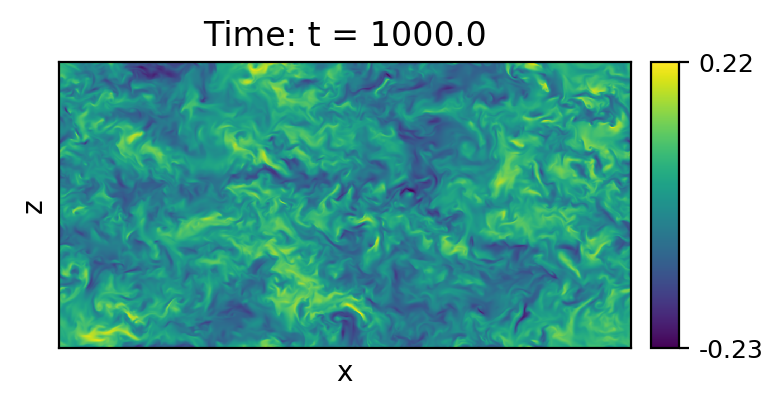

In [14]:
# plot an spanwise xz slice
yslice = Ny/2
print(yslice)
reader.sub_domain = (0,yslice,0), (reader.domain_size[0]-1, yslice, reader.domain_size[2]-1)
step = 20#max(steps)
visualize_one(reader, step, qname='v',plane='xz',cmap='viridis',savename="") # 02:viridis,08:inferno,20:magma

In [10]:
# plot all, don't forget to check reader.subdomain
qname = 'v'
plane = 'xz'

if plane=='xy':
    zslice = Nz/2
    reader.sub_domain = (0,0,zslice), (reader.domain_size[0]-1, reader.domain_size[1]-1, zslice)
elif plane=='xz':
    yslice = Ny/2
    reader.sub_domain = (0,yslice,0), (reader.domain_size[0]-1, yslice, reader.domain_size[2]-1)

for step in steps[:]:
    savename = directory+"/img/slice_%s_%s_%04d.png"%(plane,qname,step)
    visualize_one(reader, step, qname='v', plane=plane,cmap='inferno',dtheta=0,domega=0,savename=savename) 
print('Done')

Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc02/rr3/1024x1448x512//img/slice_xz_v_0000.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc02/rr3/1024x1448x512//img/slice_xz_v_0058.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc02/rr3/1024x1448x512//img/slice_xz_v_0059.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc02/rr3/1024x1448x512//img/slice_xz_v_0060.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc02/rr3/1024x1448x512//img/slice_xz_v_0061.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc02/rr3/1024x1448x512//img/slice_xz_v_0062.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc02/rr3/1024x1448x512//img/slice_xz_v_0063.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc02/rr3/1024x1448x512//img/slice_xz_v_0064.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc02/rr3/1024